<a href="https://colab.research.google.com/github/EvgenyVasilets/Perpective_Taking_prediction/blob/main/RoBERTa_pipeline_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import output
!pip install datasets
!pip install transformers
output.clear()

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
import nltk
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
import os, sys

In [ ]:
# upload a dataset 

file_path_Evgeny = "/content/drive/MyDrive/Colab Notebooks/dialogues_v3_Evgeny.xlsx"
file_path_Tijs = "/content/drive/MyDrive/Colab Notebooks/dialogues_v3_Tijs.xlsx"
col_names = ['id', 'pagetitle', 'orig_user', 'reply_user', 'orig', 'reply',
       'disagreement', 'orig_id', 'reply_id', 'orig_toxicity',
       'orig_severe_toxicity', 'reply_toxicity', 'reply_severe_toxicity',
       'conv_id', 'COP', 'COP_flag', 'COP_why', 'FCG', 'FCG_flag',
       'FCG_why', 'RT', 'RT_flag', 'RT_why', 'PS',
       'PS_flag', 'PS_why', 'Overall comment', 'escalated']
csv_parameters = {
        'header' : 1, 
        'names' : col_names, 
        'index_col' :'id', 
        'convert_float' : True}

df_Evgeny = pd.read_excel(file_path_Evgeny, **csv_parameters)
df_Tijs = pd.read_excel(file_path_Tijs, **csv_parameters)

df = pd.concat([df_Evgeny, df_Tijs])

df = df.convert_dtypes()

# choose appropriate columns. drop lines without disagreement.
df_ess = df[['orig', 'reply', 'COP', 'FCG', 'RT', 'PS']].dropna()
labels = ['COP', 'FCG', 'RT', 'PS']



# Split dataset by train+val and test

In [ ]:
randoms_states = [10, 100, 1000]
from sklearn.model_selection import train_test_split
from transformers import RobertaTokenizer


In [ ]:

# Test and train data split
df_train, df_test = train_test_split(df_ess, random_state = 42, test_size = .2)
# Divide by train and test datasets
X_train = list(df_train['reply'])
X_test = list(df_test['reply'])
y_all_train = df_train[labels]
y_all_test = df_test[labels]
# example label
label = 'RT'
y_train = y_all_train[label].tolist()
y_test = y_all_test[label].tolist()
# Divide train by train and dev
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42) # 0.2 x 0.8 = 0.16

print('X_train length:', len(X_train))
print('X_val length:', len(X_val))
print('X_test length:', len(X_test))

X_train length: 1072
X_val length: 268
X_test length: 335


In [ ]:
os.path.isdir('new_folder')

# RoBERTa

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")


loading file https://huggingface.co/roberta-base/resolve/main/vocab.json from cache at /root/.cache/huggingface/transformers/d3ccdbfeb9aaa747ef20432d4976c32ee3fa69663b379deb253ccfce2bb1fdc5.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab
loading file https://huggingface.co/roberta-base/resolve/main/merges.txt from cache at /root/.cache/huggingface/transformers/cafdecc90fcab17011e12ac813dd574b4b3fea39da6dd817813efa010262ff3f.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
loading file https://huggingface.co/roberta-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/roberta-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/roberta-base/resolve/main/tokenizer_config.json from cache at None
loading file https://huggingface.co/roberta-base/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/d53fc0fa09b8342651efd4073d75e19617b3e51287c2a535becda5

In [ ]:
train_encodings = tokenizer(X_train, truncation=True, padding=True)
test_encodings = tokenizer(X_test, truncation=True, padding=True)
val_encodings = tokenizer(X_val, truncation=True, padding=True)



In [ ]:
import tensorflow as tf

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train
))

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    y_test
))

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    y_val
))

In [ ]:
from transformers import TFRobertaForSequenceClassification, TFTrainer, TFTrainingArguments, logging

logging.set_verbosity_info()

training_args = TFTrainingArguments(
    output_dir='./results',         # output directory
    evaluation_strategy="steps",
    eval_steps = 50,
    num_train_epochs=5,              # total number of training epochs
    per_device_train_batch_size=8,  # batch size per device during training
    per_device_eval_batch_size=16,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.1,               # strength of weight decay
    logging_steps=10,
    logging_dir='./logs',
    log_level = 'info',
    logging_first_step = True,
    disable_tqdm = False
)



PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
from datasets import load_metric
from sklearn.metrics import precision_recall_fscore_support

# metric = load_metric("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='macro')
    return {
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [ ]:
with training_args.strategy.scope():
    model = TFRobertaForSequenceClassification.from_pretrained('roberta-base')



loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.8.2",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading weights file https://huggingface.co/roberta-base/resolve/main/tf_model.h5 from ca

In [ ]:
trainer = TFTrainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,           # evaluation dataset
    compute_metrics = compute_metrics)

trainer.train()

You are instantiating a Trainer but W&B is not installed. To use wandb logging, run `pip install wandb && wandb login` see https://docs.wandb.com/huggingface.
To use comet_ml logging, run `pip/conda install comet_ml` see https://www.comet.ml/docs/python-sdk/huggingface/
***** Running training *****
  Num examples = 1072
  Num Epochs = 5.0
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Steps per epoch = 134
  Total optimization steps = 670


{'loss': 0.6678722, 'learning_rate': 1e-07, 'epoch': 0.007462686567164179, 'step': 1}
{'loss': 0.6525522, 'learning_rate': 1e-06, 'epoch': 0.07462686567164178, 'step': 10}
{'loss': 0.63964754, 'learning_rate': 2e-06, 'epoch': 0.14925373134328357, 'step': 20}
{'loss': 0.6302148, 'learning_rate': 2.9999999e-06, 'epoch': 0.22388059701492538, 'step': 30}
{'loss': 0.6162568, 'learning_rate': 4e-06, 'epoch': 0.29850746268656714, 'step': 40}
***** Running Evaluation *****
  Num examples in dataset = 268
  Num examples in used in evaluation = 272
  Batch size = 16


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
{'eval_loss': 0.5460033416748047, 'eval_f1': 0.44715447154471544, 'eval_precision': 0.40441176470588236, 'eval_recall': 0.5, 'epoch': 0.373134328358209, 'step': 50}
{'loss': 0.6146742, 'learning_rate': 5.0000003e-06, 'epoch': 0.373134328358209, 'step': 50}
{'loss': 0.60791653, 'learning_rate': 5.9999998e-06, 'epoch': 0.44776119402985076, 'step': 60}
{'loss': 0.5886943, 'learning_rate': 6.9999996e-06, 'epoch': 0.5223880597014925, 'step': 70}
{'loss': 0.5840543, 'learning_rate': 8e-06, 'epoch': 0.5970149253731343, 'step': 80}
{'loss': 0.56585354, 'learning_rate': 9e-06, 'epoch': 0.6716417910447762, 'step': 90}
***** Running Evaluation *****
  Num examples in dataset = 268
  Num exam

In [ ]:
tester = TFTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)
evaluation = tester.evaluate()

You are instantiating a Trainer but W&B is not installed. To use wandb logging, run `pip install wandb && wandb login` see https://docs.wandb.com/huggingface.
To use comet_ml logging, run `pip/conda install comet_ml` see https://www.comet.ml/docs/python-sdk/huggingface/
***** Running Evaluation *****
  Num examples in dataset = 335
  Num examples in used in evaluation = 336
  Batch size = 16


{'eval_loss': 0.2739540281749907, 'eval_f1': 0.6576770945702984, 'eval_precision': 0.8366277685163135, 'eval_recall': 0.6168664737494833, 'epoch': 0, 'step': 0}


In [ ]:
evaluation

{'eval_f1': 0.6576770945702984,
 'eval_loss': 0.2739540281749907,
 'eval_precision': 0.8366277685163135,
 'eval_recall': 0.6168664737494833}

In [ ]:
output = tester.predict(test_dataset)
logits, labels = output[0], output[1]

pred = np.argmax(logits, axis=-1)


***** Running Prediction *****
  Num examples in dataset = 335
  Batch size = 16


In [ ]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay
cm=confusion_matrix(y_test, pred)
cm

array([[ 10,  31],
       [  3, 291]])

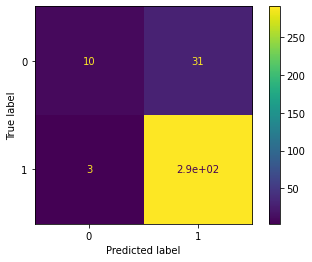

In [ ]:
cmd = ConfusionMatrixDisplay(cm, display_labels = [0,1])
cmd.plot()